---
# **DETECTOR DE DISTANCIAMIENTO SOCIAL**
##Proyecto Intermedio - Computación Gráfica
---

## **PRESENTACION**

###**Objetivo:**

El objetivo de esta tarea es analizar un video captado por una cámara en la calle y determinar que los peatones están manteniendo la distancia segura para contagio de Covid-19.

###**Datos de entrada:**

**- Video de entrada_** 
>Video del dataset OXFORD TOWN CENTRE.
>Esta información se encuentra en el siguiente enlace

>(http://www.robots.ox.ac.uk/ActiveVision/Research/Projects/2009bbenfold_headpose/Datasets/TownCentreXVID.avi)

**- Data bounding box_** 
>Información relacionada al bounding box de cada persona en cada frame del video

>El fichero con la data esta en formato csv.
>Esta información se encuentra en el siguiente enlace

>(http://www.robots.ox.ac.uk/ActiveVision/Research/Projects/2009bbenfold_headpose/Datasets/TownCentre-groundtruth.top)


###**Enlaces:**


**- GitHub:**

**- Video :** https://youtu.be/UC7NGGMR-ko


---


***Daniel W. Silva Rufino***

---



## **DESARROLLO DEL PROYECTO**

Para lograr el objetivo del proyecto se ha seguido 3 pasos.

Primero obtenemos los datos de entrada, las fuentes e importamos librerías.

In [0]:
import cv2
import matplotlib.pyplot as plt
import math
import numpy as np
import DataProcessing as datap
from Util import *
from View import *

##1.- Transfomación de la data
El video de entrada se muestra como una captura desde un angulo lateral, lo que para conseguir la vista panoramica superior o "Bird's Eye View", es necesario realizar una transformación de la perspectiva que se muestra en el video.

Los pasos a ejecutar son:


###a. Identificar puntos de referencia

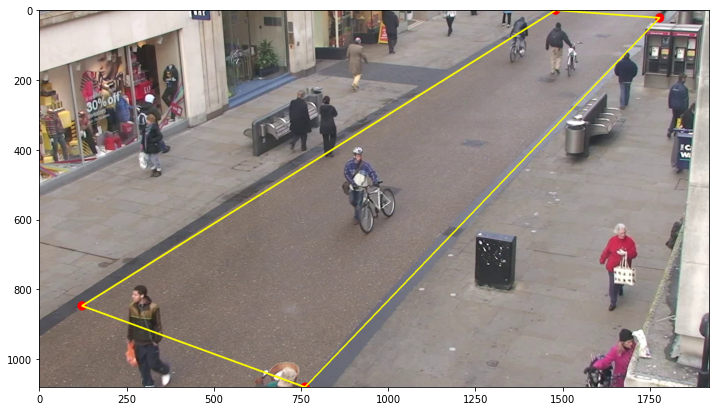

In [4]:
#Obtenemos el primer frame del video como referencia.
frame_ini = cv2.cvtColor(cv2.imread('Resources/images/frame1.jpg'), cv2.COLOR_BGR2RGB)
frame_ref = frame_ini.copy()
img_src_points = np.float32([[1480, 0], [123, 847], [762, 1080], [1778, 22]])

for point in img_src_points:
    cv2.circle(frame_ref, tuple(point), 8, (255,0,0), 10)

cv2.polylines(frame_ref,np.int32([img_src_points]), True, (255,255,0), thickness=4)

plt.figure(figsize=(12, 12))
plt.imshow(frame_ref)
plt.show()

###b. Calcular matriz de transformación

In [5]:
pts_ori = np.float32([[1480, 0], [123, 847], [762, 1080], [1778, 22]])
pts_dest = np.float32([[1100, 80], [1100, 1000], [1300, 1000], [1300, 80]])
matrix = cv2.getPerspectiveTransform(pts_ori, pts_dest)
matrix

array([[ 7.76161530e-01,  3.67548677e+00,  6.05078592e+01],
       [-2.07739930e-01,  3.07210633e+00,  3.95398872e+02],
       [ 6.70927046e-05,  2.31838078e-03,  1.00000000e+00]])

###c. Crear vista panorámica

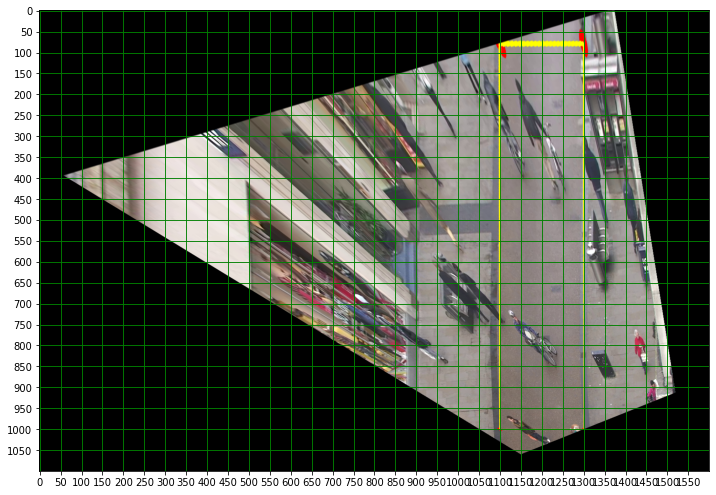

In [6]:
img_wrp = cv2.warpPerspective(frame_ref, matrix, (1600,1100))

plt.figure(figsize=(12, 12))
plt.imshow(img_wrp)
plt.xticks(np.arange(0, img_wrp.shape[1], step=50))
plt.yticks(np.arange(0, img_wrp.shape[0], step=50))
plt.grid(True, color='g', linestyle='-', linewidth=0.9)
plt.show()



##2.- Detección de bounding box
Para la detección de los bounding box se obtiene la data del csv **'TownCentre-groundtruth'**, es un dataset con informacion de 4500 frames.

Los datos que tiene son:

* 'numPersona'
* 'numFrame'
* 'headValid'
* 'bodyValid'
* 'headLeft'
* 'headTop'
* 'headRight'
* 'headBottom'
* 'bodyLeft'
* 'bodyTop'
* 'bodyRight'
* 'bodyBottom'


In [0]:
file_csv = 'Resources/data/TownCentre-groundtruth.top'
df = datap.prepare_data(file_csv)
data_frame = df[df['numFrame'] == 0]

list_index, list_points = datap.process_df2bev(data_frame)

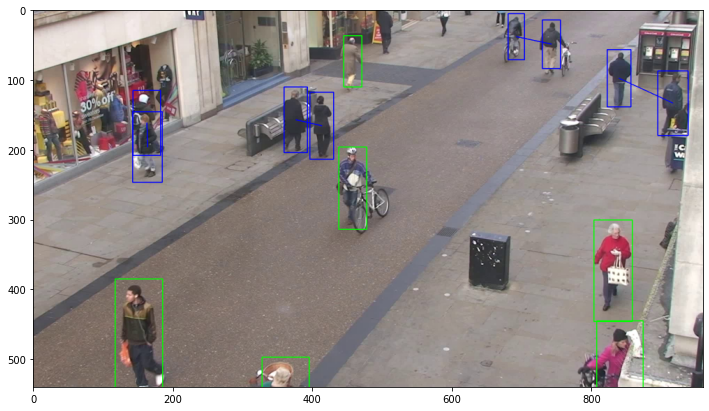

(540, 960, 3)


In [10]:
min_separation_dist = 100

g_cerca,g_lejos = get_group_distance(list_index, list_points, min_separation_dist)
img_bbox = get_image_camera(frame_ini, data_frame, g_cerca, g_lejos)

plt.figure(figsize=(12,12))
plt.imshow(img_bbox)
plt.show()
print(img_bbox.shape)

##3.- Proyección vista panorámica
Del procesamiento de los puntos que registra el csv, se obtiene dos grupos de personas (array de puntos), las que cumplen el distanciamiento y las que no.

**En el último paso se proceso la información, se utilizará la funcion que devuelve la imagen que corresponde a la Bird's Eye View.*

(540, 303, 3)


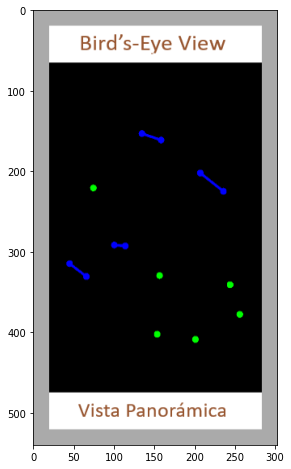

In [12]:
img_bev = get_image_bev( g_cerca, g_lejos, min_separation_dist)
print(img_bev.shape)
plt.figure(figsize=(8,8))
plt.imshow(img_bev)
plt.show()

**Vista completa del Detector de Distanciamiento Social**

(587, 1280, 3)


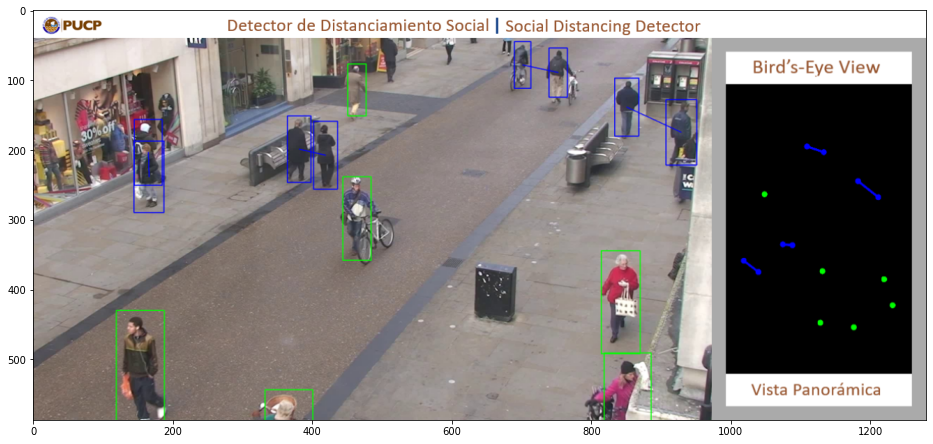

In [13]:
img_final = join_images(img_bbox, img_bev, 1)
img_final = join_images(img_header, img_final, 0)

print(img_final.shape)
plt.figure(figsize=(16,16))
plt.imshow(img_final)
plt.show()

## **GENERACIÓN DE VIDEO**

In [0]:
file_csv = 'Resources/data/TownCentre-groundtruth.top'
num_frame = -1
min_separation_dist=40
df = datap.prepare_data(file_csv)

video_out = cv2.VideoWriter('DistanciamientoSocial.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 25,(1280, 587))

cap = cv2.VideoCapture('Resources/video/TownCentreXVID.avi')

while cap.isOpened():
    _, frame = cap.read()

    num_frame+=1

    data_frame = df[df['numFrame'] == num_frame]
    
    if frame is None:
      break
    
    if data_frame.shape[0] == 0 :
      break

    list_index, list_points = datap.process_df2bev(data_frame)
    g_cerca,g_lejos = get_group_distance(list_index, list_points, min_separation_dist)

    img_bev = get_image_bev( g_cerca, g_lejos, min_separation_dist)
    img_bbox = get_image_camera(frame, data_frame, g_cerca, g_lejos)

    frame_final = join_images(img_bbox, img_bev, 1)
    frame_final = join_images(img_header, frame_final, 0)

    if video_out is not None:
      video_out.write(frame_final)

if video_out is not None:
  video_out.release()

cap.release()

